In [73]:
#convert unstructured data into structured. 
import pandas as pd
import ast
from typing import Union, Dict, List, Any

def parse_dict(value: Any) -> Union[Dict, List, Any]:
    """Parse string representation of dict/list into actual dict/list"""
    if isinstance(value, str):
        try:
            return ast.literal_eval(value)
        except:
            return value
    return value

def flatten_list_of_dicts(lst: List[Dict]) -> Dict[str, Any]:
    """Flatten a list of dictionaries into a single dictionary"""
    result = {}
    if not lst:
        return result

    for idx, item in enumerate(lst):
        if isinstance(item, dict):
            for key, value in item.items():
                # Handle nested lists of dictionaries
                if isinstance(value, list) and value and isinstance(value[0], dict):
                    nested_flat = flatten_list_of_dicts(value)
                    for nested_key, nested_value in nested_flat.items():
                        result[f"{key}_{nested_key}"] = nested_value
                else:
                    result[f"{key}_{idx}"] = value
        else:
            result[f"item_{idx}"] = item
    return result

def flatten_nested_dict(d: Dict[str, Any], parent_key: str = '', sep: str = '_') -> Dict[str, Any]:
    """Recursively flatten nested dictionary"""
    items: List = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k

        if isinstance(v, dict):
            items.extend(flatten_nested_dict(v, new_key, sep=sep).items())
        elif isinstance(v, list):
            if v and isinstance(v[0], dict):
                flat_list = flatten_list_of_dicts(v)
                for list_key, list_value in flat_list.items():
                    items.append((f"{new_key}{sep}{list_key}", list_value))
            else:
                items.append((new_key, ', '.join(map(str, v)) if v else ''))
        else:
            items.append((new_key, v))
    return dict(items)

def process_dataframe(df: pd.DataFrame) -> pd.DataFrame:
    """Process the entire dataframe to flatten all nested structures"""
    # First pass: Parse all string representations of dicts/lists
    for column in df.columns:
        df[column] = df[column].apply(parse_dict)

    # Second pass: Flatten all nested structures
    flattened_data = []

    for _, row in df.iterrows():
        flat_row = {}
        for column, value in row.items():
            if isinstance(value, dict):
                flat_dict = flatten_nested_dict(value)
                for k, v in flat_dict.items():
                    flat_row[f"{column}_{k}"] = v
            elif isinstance(value, list):
                if value and isinstance(value[0], dict):
                    flat_list = flatten_list_of_dicts(value)
                    for k, v in flat_list.items():
                        flat_row[f"{column}_{k}"] = v
                else:
                    flat_row[column] = ', '.join(map(str, value)) if value else ''
            else:
                flat_row[column] = value
        flattened_data.append(flat_row)

    return pd.DataFrame(flattened_data)


# Read your data
df1 = pd.read_excel('chennai_cars.xlsx')  # or however you're loading your data
df2 = pd.read_excel('jaipur_cars.xlsx')
df3 = pd.read_excel('delhi_cars.xlsx')
df4 = pd.read_excel('kolkata_cars.xlsx')
df5 = pd.read_excel('bangalore_cars.xlsx')
df6 = pd.read_excel('hyderabad_cars.xlsx')
# Process the dataframe
flattened_df1 = process_dataframe(df1)
flattened_df2 = process_dataframe(df2)
flattened_df3 = process_dataframe(df3)
flattened_df4 = process_dataframe(df4)
flattened_df5 = process_dataframe(df5)
flattened_df6 = process_dataframe(df6)
# Optional: Clean up column names
flattened_df3.columns = [col.lower().replace(' ', '_') for col in flattened_df3.columns]
flattened_df1.columns = [col.lower().replace(' ', '_') for col in flattened_df1.columns]
flattened_df2.columns = [col.lower().replace(' ', '_') for col in flattened_df2.columns]  
flattened_df4.columns = [col.lower().replace(' ', '_') for col in flattened_df4.columns]
flattened_df5.columns = [col.lower().replace(' ', '_') for col in flattened_df5.columns]
flattened_df6.columns = [col.lower().replace(' ', '_') for col in flattened_df6.columns]

# Save to Excel or CSV
flattened_df1.to_excel('Structured_Jaipur.xlsx', index=False)
flattened_df2.to_excel('Structured_Chennai.xlsx', index=False)
flattened_df3.to_excel('Structured_Delhi.xlsx', index=False)
flattened_df4.to_excel('Structured_Kolkata.xlsx', index=False)
flattened_df5.to_excel('Structured_Hyderabad.xlsx', index=False)
flattened_df6.to_excel('Structured_Bangalore.xlsx', index=False)

# Print shape to verify
print(f"Original shape: {df.shape}")


Original shape: (8369, 18)


In [81]:
#concatenate, add a city column and convert all milage and price columns into numeric
import pandas as pd
import numpy as np
import os
import warnings

#concatenate all datasets add a new column named "city"
warnings.filterwarnings("ignore")

file_path = {'Bangalore':'Structured_Bangalore.xlsx',
             'Chennai':"Structured_Chennai.xlsx",
             'Delhi':"Structured_Delhi.xlsx",
             'Hyderabad':"Structured_Hyderabad.xlsx",
             'Jaipur':"Structured_Jaipur.xlsx",
             'Kolkata':"Structured_Kolkata.xlsx"}

try:
    # Create a list to store the DataFrames
    dfs = []
    # Loop through the file paths and read each Excel file into a DataFrame
    for city, file in file_path.items():
        df = pd.read_excel(file)
        df['City'] = city # Add a new column 'City' and assign the city name
        dfs.append(df) # append the DataFrame to the list

    # Concatenate all DataFrames in the list
    Cars = pd.concat(dfs)
    Cars.to_csv("Cars.csv")
except Exception as e:
    print(f"An error occurred: {e}")
    raise e

df=pd.read_csv("Cars.csv")

# Convert mileage columns to numeric
df['new_car_detail_km'] = df['new_car_detail_km'].str.replace(' kms', '').str.replace(',', '').astype(int)

# Convert price columns to numeric, handling 'Lakh' and 'Crore' correctly
df['new_car_detail_price'] = df['new_car_detail_price'].astype(str).str.replace('₹', '').str.replace(',', '').str.replace(' Lakh', '*100000').str.replace('Crore', '*10000000').apply(lambda x: eval(x) if '*' in x else '')
df['new_car_detail_priceactual'] = df['new_car_detail_priceactual'].astype(str).str.replace('₹', '').str.replace(',', '').str.replace(' Lakh', '*100000').str.replace(' Crore', '*10000000').apply(lambda x: eval(x) if '*' in x else '')

df.to_csv("Cars.csv", index=False) #saving without index
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Columns: 171 entries, Unnamed: 0 to new_car_feature_data_list_value_47
dtypes: float64(8), int32(1), int64(5), object(157)
memory usage: 10.9+ MB


In [311]:
#  Check for all data types and do the necessary steps to keep the data in the correct format
import pandas as pd
df=pd.read_csv("Cars.csv")
def process_mileage(df):
    # Extract numeric part and unit
    df[['mileage_value', 'mileage_unit']] = df['new_car_specs_top_value_0'].str.extract(r'([\d.]+)\s*([a-zA-Z]+)')
    df['mileage_value'] = pd.to_numeric(df['mileage_value'], errors='coerce')
    df[['horsepower_value', 'horsepower_unit']] = df['new_car_specs_top_value_2'].str.extract(r'([\d.]+)\s*([a-zA-Z]+)')
    df['horsepower_value'] = pd.to_numeric(df['horsepower_value'], errors='coerce')
    df[['engine_value', 'engine_unit']] = df['new_car_specs_top_value_1'].str.extract(r'([\d.]+)\s*([a-zA-Z]+)')
    df['engine_value'] = pd.to_numeric(df['engine_value'], errors='coerce')
    df[['torque_value', 'torque_unit']] = df['new_car_specs_top_value_3'].str.extract(r'([\d.]+)\s*([a-zA-Z]+)')
    df['torque_value'] = pd.to_numeric(df['torque_value'], errors='coerce')
    df[['gearbox_value', 'gearbox_unit']] = df['new_car_specs_data_list_value_0'].str.extract(r'([\d.]+)\s*([a-zA-Z]+)')
    df['gearbox_value'] = pd.to_numeric(df['gearbox_value'], errors='coerce')
    df[['seats_value', 'seats_unit']] = df['new_car_overview_top_value_3'].str.extract(r'([\d.]+)\s*([a-zA-Z]+)')
    df['seats_value'] = pd.to_numeric(df['seats_value'], errors='coerce')

    return df

# Example usage
df = process_mileage(df)
df.to_csv("Cars1.csv", index=False)
print(df.head())

   Unnamed: 0  new_car_detail_it new_car_detail_ft new_car_detail_bt  \
0           0                  0            Petrol         Hatchback   
1           1                  0            Petrol               SUV   
2           2                  0            Petrol         Hatchback   
3           3                  0            Petrol             Sedan   
4           4                  0            Diesel               SUV   

   new_car_detail_km new_car_detail_transmission  new_car_detail_ownerno  \
0             120000                      Manual                       3   
1              32706                      Manual                       2   
2              11949                      Manual                       1   
3              17794                      Manual                       1   
4              60000                      Manual                       1   

  new_car_detail_owner new_car_detail_oem new_car_detail_model  ...  \
0            3rd Owner             Maru

In [795]:
# remove mixed data types 
#Load the data
df = pd.read_csv('Cars1.csv')
# List of columns you want to keep, regardless of their data type
columns_to_keep = ['new_car_detail_oem','new_car_detail_bt', 'new_car_detail_owner','mileage_unit', 'horsepower_unit','engine_unit','torque_unit','torque_value','horsepower_value','engine_value']

# Identify columns with mixed data types, excluding the ones you want to keep
mixed_type_columns = [
    col for col in df.columns if col not in columns_to_keep and
    df[col].apply(lambda x: isinstance(x, str)).any() and
    df[col].apply(lambda x: isinstance(x, (int, float))).any()
]

# Drop mixed data type columns, except for the ones you want to keep
df.drop(columns=mixed_type_columns, inplace=True)
df.to_csv("Cars_clean1.csv", index=False)
print(f"Removed mixed data type columns: {mixed_type_columns}")
print(f"Kept columns: {columns_to_keep}")

Removed mixed data type columns: ['new_car_overview_top_value_5', 'new_car_overview_top_key_6', 'new_car_overview_top_value_6', 'new_car_overview_top_icon_6', 'new_car_overview_top_key_7', 'new_car_overview_top_value_7', 'new_car_overview_top_icon_7', 'new_car_overview_top_key_8', 'new_car_overview_top_value_8', 'new_car_overview_top_icon_8', 'new_car_overview_top_key_9', 'new_car_overview_top_icon_9', 'new_car_feature_top_value_0', 'new_car_feature_top_value_1', 'new_car_feature_top_value_2', 'new_car_feature_top_value_3', 'new_car_feature_top_value_4', 'new_car_feature_top_value_5', 'new_car_feature_top_value_6', 'new_car_feature_top_value_7', 'new_car_feature_data_heading_0', 'new_car_feature_data_subheading_0', 'new_car_feature_data_list_value_0', 'new_car_feature_data_list_value_1', 'new_car_feature_data_list_value_2', 'new_car_feature_data_list_value_3', 'new_car_feature_data_list_value_4', 'new_car_feature_data_list_value_5', 'new_car_feature_data_list_value_6', 'new_car_feature

In [797]:
df=pd.read_csv("Cars_clean1.csv")
df.shape


(8369, 72)

In [799]:
df=pd.read_csv("Cars_clean1.csv")
df.isnull().sum()

Unnamed: 0              0
new_car_detail_it       0
new_car_detail_ft       0
new_car_detail_bt       4
new_car_detail_km       0
                     ... 
torque_value          491
torque_unit           491
gearbox_value        1571
seats_value             0
seats_unit              0
Length: 72, dtype: int64

In [292]:
#drop unnecessary columns

# Load the data
df = pd.read_csv('Cars_clean1.csv')

# List of columns to drop
# List of columns to drop
columns_to_drop = ['Unnamed: 0','new_car_detail_it', 'new_car_detail_oem','new_car_detail_variantname', 'new_car_detail_priceactual','new_car_specs_data_list_value_3','new_car_specs_data_list_value_1','new_car_detail_ownerno','new_car_detail_centralvariantid','new_car_detail_pricefixedtext', 'new_car_detail_trendingtext_imgurl', 'new_car_detail_trendingtext_heading', 'new_car_detail_trendingtext_desc', 'new_car_overview_heading', 'new_car_overview_top_key_0',
                   'new_car_overview_top_value_0', 'new_car_overview_top_icon_0', 'new_car_overview_top_key_1', 'new_car_overview_top_value_1', 'new_car_overview_top_icon_1', 'new_car_overview_top_key_2', 'new_car_overview_top_value_2','new_car_specs_data_list_key_0_0','new_car_specs_data_list_key_1_0','new_car_specs_data_list_value_10_1','new_car_specs_data_list_value_11_1',
                    'new_car_overview_top_icon_2', 'new_car_overview_top_key_3', 'new_car_overview_top_value_3', 'new_car_overview_top_icon_3', 'new_car_overview_top_key_4', 'new_car_overview_top_value_4', 'new_car_overview_top_icon_4', 'new_car_overview_top_key_5', 'new_car_overview_top_icon_5',
                     'new_car_overview_top_value_9', 'new_car_overview_bottomdata', 'new_car_feature_heading', 'new_car_feature_commonicon', 'new_car_specs_heading', 'new_car_specs_top_key_0', 'new_car_specs_top_value_0', 'new_car_specs_top_value_5', 'new_car_specs_data_heading_0', 'new_car_specs_data_subheading_0', 'new_car_specs_data_list_key_0', 'new_car_specs_data_list_value_0',
                  'new_car_specs_data_list_key_1', 'new_car_specs_data_list_key_2', 'new_car_specs_data_list_value_2', 'new_car_specs_data_list_key_3', 'engine_unit','torque_unit','seats_unit','new_car_specs_data_list_value_1_0',
                   'new_car_specs_commonicon', 'car_links', 'new_car_feature_top', 'new_car_feature_data', 'mileage_unit', 'horsepower_unit','new_car_detail_pricesaving', 'new_car_specs_commonicon','seats_unit']


                   # Drop the specified columns
df = df.drop(columns=columns_to_drop, errors='ignore')

# Save the modified DataFrame
df.to_csv("Cars_clean2.csv", index=False)

In [294]:
df.shape

(8369, 15)

In [296]:
df=pd.read_csv("Cars_clean2.csv")
df.isnull().sum()

new_car_detail_ft                 0
new_car_detail_bt                 4
new_car_detail_km                 0
new_car_detail_transmission       0
new_car_detail_owner              0
new_car_detail_model              0
new_car_detail_modelyear          0
new_car_detail_price            110
City                              0
mileage_value                     3
horsepower_value                228
engine_value                     25
torque_value                    491
gearbox_value                  1571
seats_value                       0
dtype: int64

In [298]:
import pandas as pd
import numpy as np
# Load the dataframe
df = pd.read_csv('Cars_clean2.csv')
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64','int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Check for missing values in numerical columns
numerical_missing = df[numerical_cols].isnull().sum()
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())
# Check for missing values in categorical columns
categorical_missing = df[categorical_cols].isnull().sum()
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

# Save the imputed dataframe
df.to_csv('Cars_clean3.csv', index=False)
df.isnull().sum()

new_car_detail_ft              0
new_car_detail_bt              0
new_car_detail_km              0
new_car_detail_transmission    0
new_car_detail_owner           0
new_car_detail_model           0
new_car_detail_modelyear       0
new_car_detail_price           0
City                           0
mileage_value                  0
horsepower_value               0
engine_value                   0
torque_value                   0
gearbox_value                  0
seats_value                    0
dtype: int64

In [300]:
# add car age column and save file

import pandas as pd

# Load the dataframe
df = pd.read_csv('Cars_clean3.csv')

# Assuming 'new_car_detail_mfg' represents the manufacturing year
current_year = 2024  # Replace with the current year
df['car_age'] = current_year - df['new_car_detail_modelyear']

# Save the updated DataFrame
df.to_csv('Cars_age.csv', index=False)

In [302]:
df.describe(include="all")

,new_car_detail_ft,new_car_detail_bt,new_car_detail_km,new_car_detail_transmission,new_car_detail_owner,new_car_detail_model,new_car_detail_modelyear,new_car_detail_price,City,mileage_value,horsepower_value,engine_value,torque_value,gearbox_value,seats_value,car_age
count,8369,8369,8.369000e+03,8369,8369,8369,8369.000000,8.369000e+03,8369,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000,8369.000000
unique,5,10,NaN,2,6,315,NaN,NaN,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Petrol,Hatchback,NaN,Manual,1st Owner,Honda City,NaN,NaN,Delhi,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,5554,3571,NaN,6052,5882,370,NaN,NaN,1485,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,5.897430e+04,NaN,NaN,NaN,2016.503286,9.640809e+05,NaN,73.159856,108.727845,1377.848149,174.813066,5.356578,6.849086,7.496714
std,NaN,NaN,7.406100e+04,NaN,NaN,NaN,3.921465,1.413052e+06,NaN,317.119015,58.307016,508.056847,103.372741,0.849442,32.106800,3.921465
min,NaN,NaN,0.000000e+00,NaN,NaN,NaN,1985.000000,1.000000e+05,NaN,0.000000,34.200000,25.400000,4.800000,4.000000,0.000000,1.000000
25%,NaN,NaN,3.000000e+04,NaN,NaN,NaN,2014.000000,4.040000e+05,NaN,17.010000,78.900000,1197.000000,113.000000,5.000000,5.000000,5.000000
50%,NaN,NaN,5.369200e+04,NaN,NaN,NaN,2017.000000,6.130000e+05,NaN,19.010000,88.700000,1199.000000,140.000000,5.000000,5.000000,7.000000
75%,NaN,NaN,8.000000e+04,NaN,NaN,NaN,2019.000000,9.500000e+05,NaN,21.790000,119.350000,1498.000000,200.000000,5.000000,5.000000,10.000000


In [304]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8369 entries, 0 to 8368
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   new_car_detail_ft            8369 non-null   object 
 1   new_car_detail_bt            8369 non-null   object 
 2   new_car_detail_km            8369 non-null   int64  
 3   new_car_detail_transmission  8369 non-null   object 
 4   new_car_detail_owner         8369 non-null   object 
 5   new_car_detail_model         8369 non-null   object 
 6   new_car_detail_modelyear     8369 non-null   int64  
 7   new_car_detail_price         8369 non-null   float64
 8   City                         8369 non-null   object 
 9   mileage_value                8369 non-null   float64
 10  horsepower_value             8369 non-null   float64
 11  engine_value                 8369 non-null   float64
 12  torque_value                 8369 non-null   float64
 13  gearbox_value     

In [306]:
df.to_csv('Cars_clean2.csv')
df.shape

(8369, 16)

In [308]:
df = pd.read_csv('Cars_clean2.csv')
print(df['new_car_detail_ft'].unique())

['Petrol' 'Diesel' 'Lpg' 'Cng' 'Electric']


In [310]:
df = pd.read_csv('Cars_clean2.csv')
print(df['new_car_detail_bt'].unique())

['Hatchback' 'SUV' 'Sedan' 'MUV' 'Coupe' 'Minivans' 'Pickup Trucks'
 'Convertibles' 'Hybrids' 'Wagon']


In [312]:
df = pd.read_csv('Cars_clean2.csv')
print(df['new_car_detail_model'].unique())


['Maruti Celerio' 'Ford Ecosport' 'Tata Tiago' 'Hyundai Xcent'
 'Maruti SX4 S Cross' 'Jeep Compass' 'Datsun GO' 'Hyundai Venue'
 'Maruti Ciaz' 'Maruti Baleno' 'Hyundai Grand i10' 'Honda Jazz'
 'Mahindra XUV500' 'Mercedes-Benz GLA' 'Hyundai i20' 'Tata Nexon'
 'Honda City' 'BMW 5 Series' 'Maruti Swift' 'Renault Duster'
 'Mercedes-Benz S-Class' 'Hyundai Santro' 'Hyundai Santro Xing'
 'Mercedes-Benz E-Class' 'Audi A4' 'Maruti Wagon R' 'Maruti Ertiga'
 'Mercedes-Benz C-Class' 'Toyota Fortuner' 'Hyundai Elantra' 'Audi A6'
 'Maruti Alto 800' 'Mahindra Scorpio' 'Mini 3 DOOR' 'Kia Seltos'
 'Maruti Alto' 'Mercedes-Benz GL-Class' 'Tata New Safari' 'Audi Q7'
 'Renault KWID' 'Hyundai Getz' 'Skoda Rapid' 'Hyundai Creta'
 'Tata Harrier' 'BMW 3 Series GT' 'Renault Lodgy' 'Skoda Octavia'
 'Maruti Ritz' 'Volkswagen Polo' 'Mahindra KUV 100' 'BMW X3' 'Hyundai i10'
 'Volvo S60' 'Mahindra XUV300' 'MG Hector Plus' 'Honda Brio'
 'Maruti Alto K10' 'Renault Kiger' 'Hyundai EON' 'Volkswagen Vento'
 'Toyota Yaris

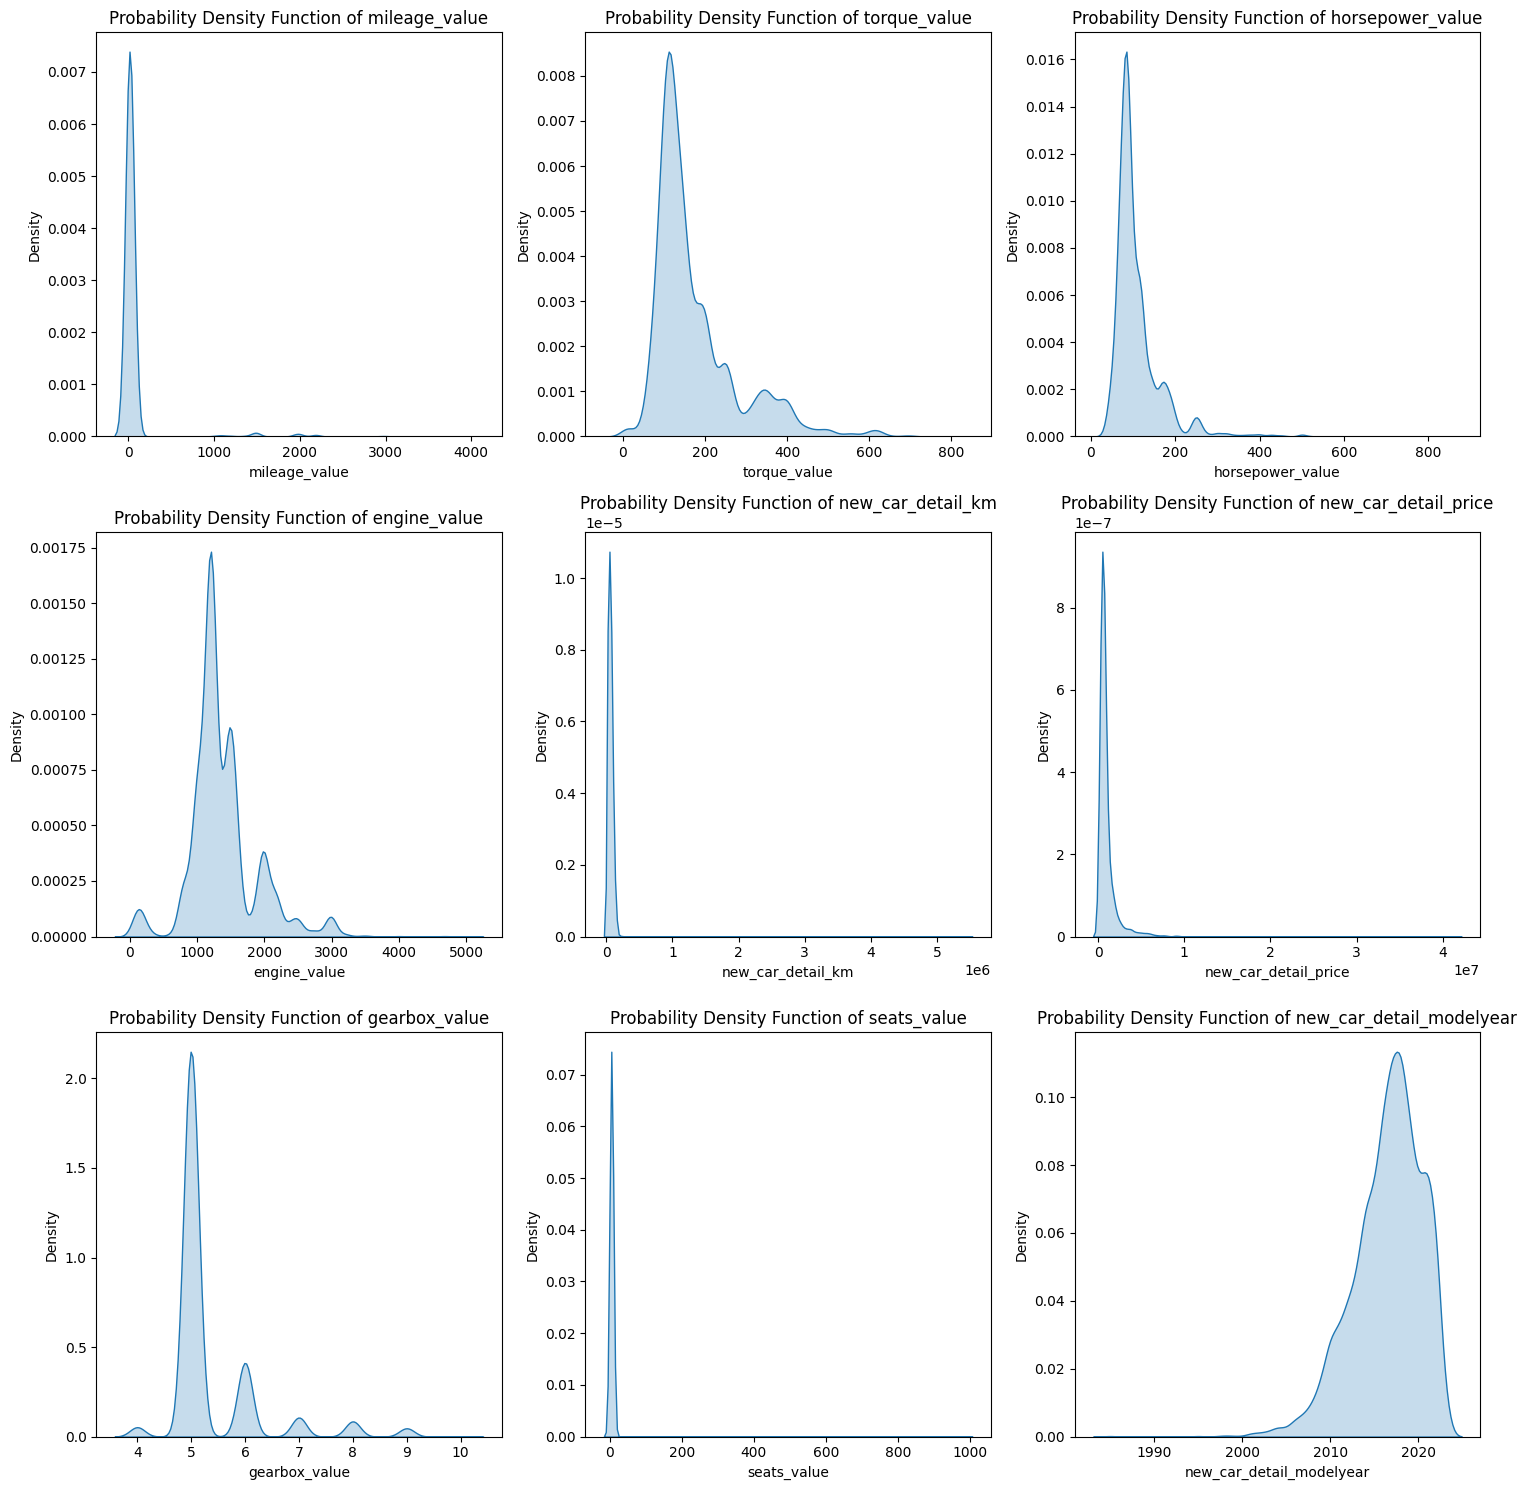

In [314]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df=pd.read_csv("Cars_age.csv")
numerical_cols = ['mileage_value', 'torque_value', 'horsepower_value', 'engine_value','new_car_detail_km', 'new_car_detail_price', 'gearbox_value','seats_value','new_car_detail_modelyear']
#calculate number of rows and columns for subplot
num_cols=len(numerical_cols)
num_rows=(num_cols+3)//4
#Creat the plots with adjusted subplot grid
plt.figure(figsize=(15,5*num_rows))
for i, col in enumerate(numerical_cols):
   plt.subplot(num_rows, 3, i+1)
   sns.kdeplot(df[col],fill=True)
   plt.title(f'Probability Density Function of {col}')
   plt.xlabel(col)
   plt.ylabel('Density')
plt.tight_layout()
plt.show()

In [324]:
#remove outlier either use quantile method or filter technique
# Load the dataset
df = pd.read_csv('Cars_age.csv')

# Filter the DataFrame
filtered_df = df[
    (df['mileage_value'] >= 1) & (df['mileage_value'] <= 400) &
    (df['horsepower_value'] >= 35) & (df['horsepower_value'] <= 500) &
    (df['seats_value'] >= 2) & (df['seats_value'] <= 10) &
    (df['engine_value'] > 600)&
    (df['new_car_detail_modelyear'] >= 2000)
]

# Display the filtered DataFrame
filtered_df.to_csv('Cars_filtered.csv', index=False)

In [326]:
df.shape

(8369, 16)

In [334]:
df=pd.read_csv("Cars_filtered.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8026 entries, 0 to 8025
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   new_car_detail_ft            8026 non-null   object 
 1   new_car_detail_bt            8026 non-null   object 
 2   new_car_detail_km            8026 non-null   int64  
 3   new_car_detail_transmission  8026 non-null   object 
 4   new_car_detail_owner         8026 non-null   object 
 5   new_car_detail_model         8026 non-null   object 
 6   new_car_detail_modelyear     8026 non-null   int64  
 7   new_car_detail_price         8026 non-null   float64
 8   City                         8026 non-null   object 
 9   mileage_value                8026 non-null   float64
 10  horsepower_value             8026 non-null   float64
 11  engine_value                 8026 non-null   float64
 12  torque_value                 8026 non-null   float64
 13  gearbox_value     

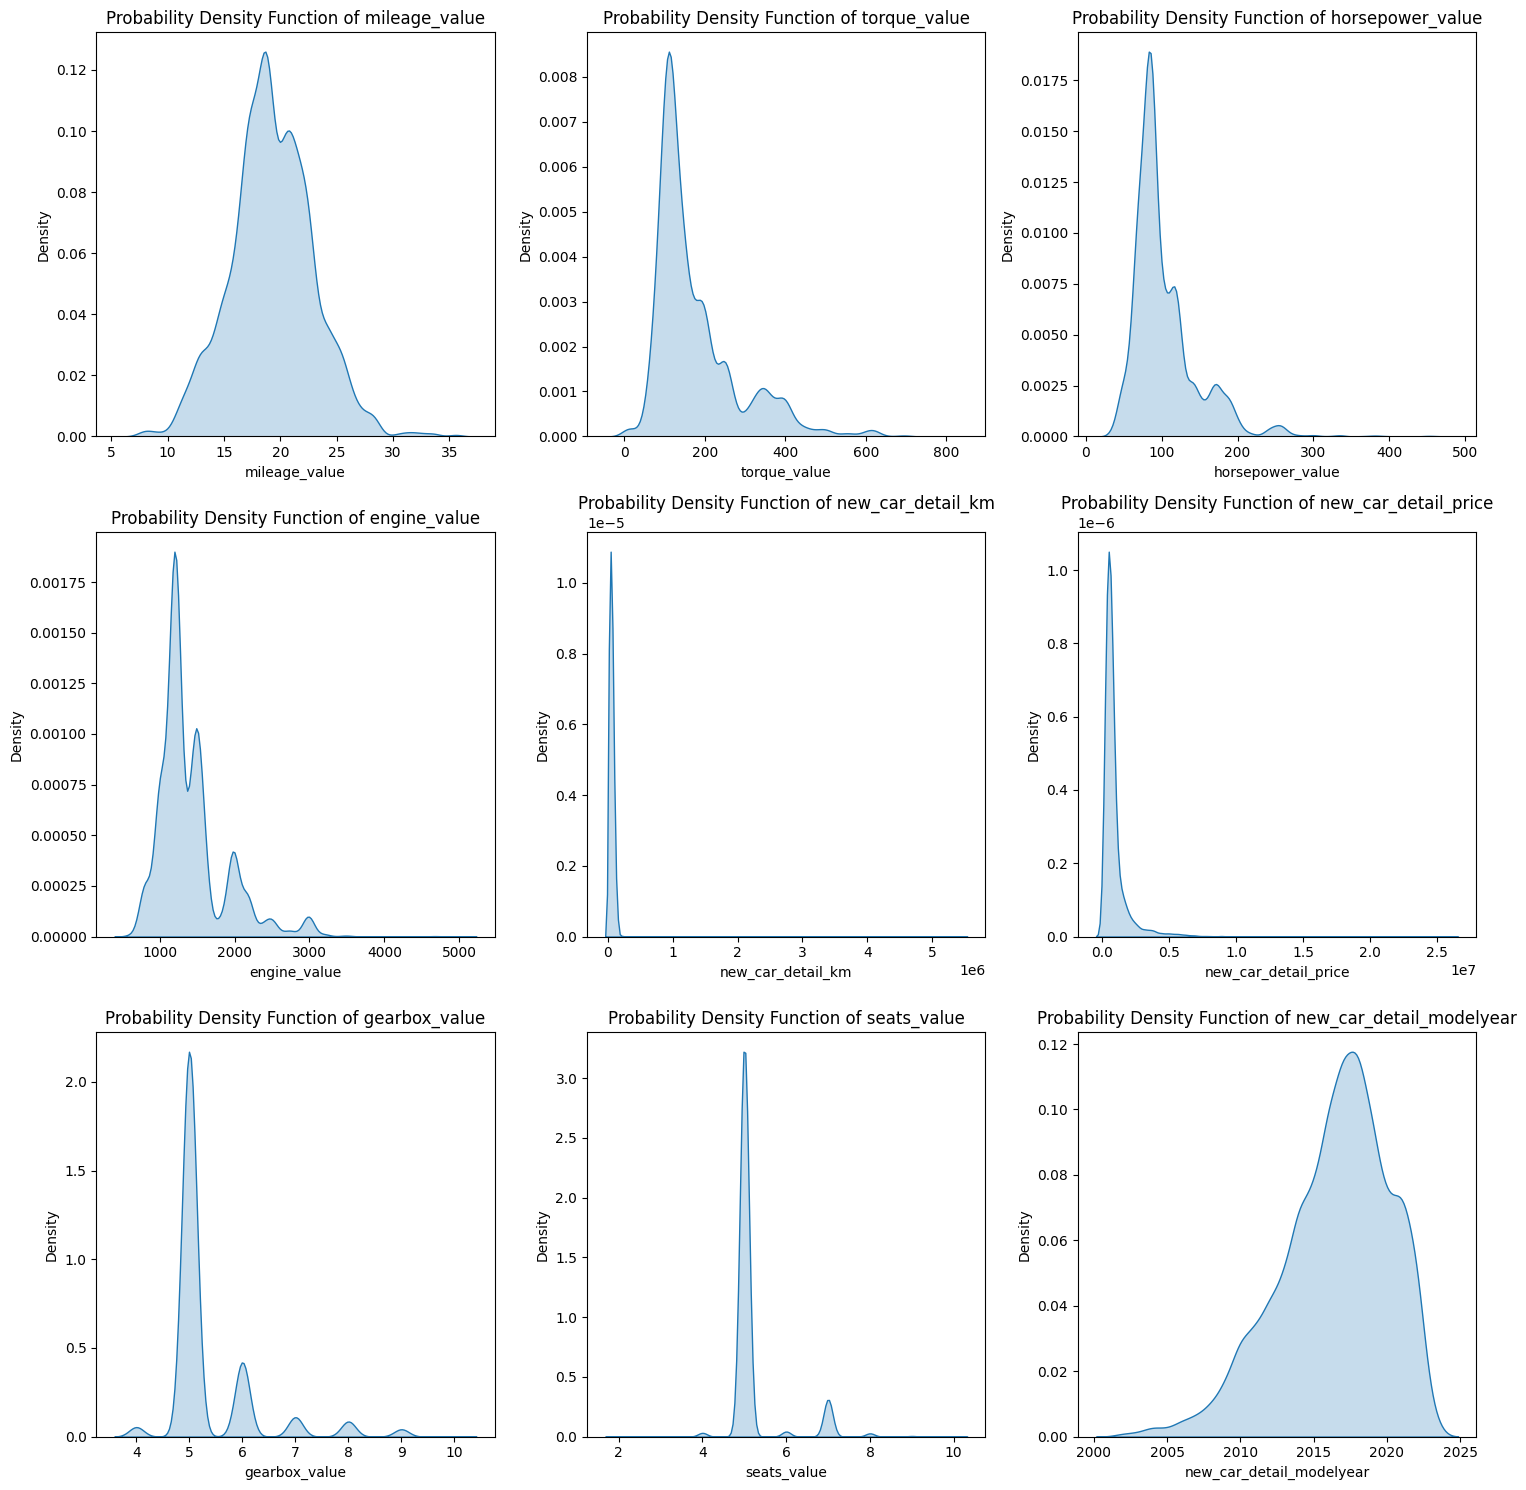

In [336]:
df=pd.read_csv("Cars_filtered.csv")
numerical_cols = ['mileage_value', 'torque_value', 'horsepower_value', 'engine_value','new_car_detail_km', 'new_car_detail_price', 'gearbox_value','seats_value','new_car_detail_modelyear']
#calculate number of rows and columns for subplot
num_cols=len(numerical_cols)
num_rows=(num_cols+3)//4
#Creat the plots with adjusted subplot grid
plt.figure(figsize=(15,5*num_rows))
for i, col in enumerate(numerical_cols):
   plt.subplot(num_rows, 3, i+1)
   sns.kdeplot(df[col],fill=True)
   plt.title(f'Probability Density Function of {col}')
   plt.xlabel(col)
   plt.ylabel('Density')
plt.tight_layout()
plt.show()

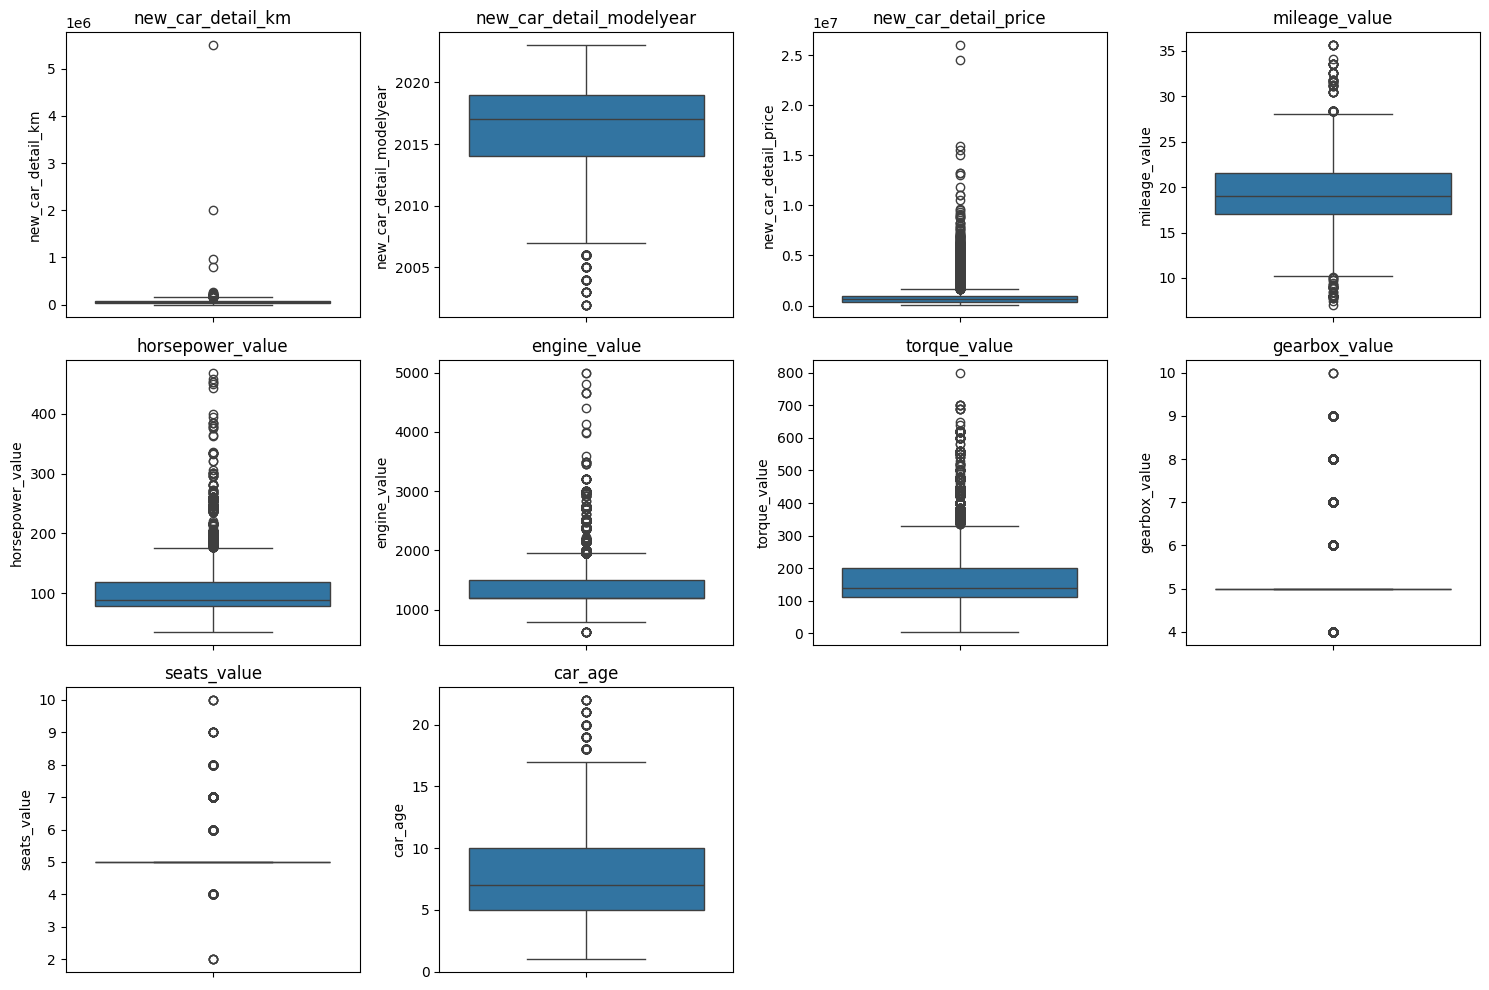

In [338]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import math
# Load the data
df = pd.read_csv('Cars_filtered.csv')

# Select numerical columns for boxplot
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Create boxplots for each numerical column
plt.figure(figsize=(15, 10))  # Adjust figure size for better visualization

for i, col in enumerate(numerical_cols):
    plt.subplot(3, 4, i + 1)  # Adjust the grid layout as needed
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.tight_layout()

plt.show()

In [340]:
#do IQR treatment
def iqr_treatment(df,column_name):
    Q1=df[col].quantile(0.25)
    Q3=df[col].quantile(0.75)
    IQR=Q3-Q1
    lower_bound=Q1-1.5*IQR
    upper_bound=Q3+1.5*IQR
    #clip the outliers
    df[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
    df[col] = np.where(df[col] > upper_bound, upper_bound, df[col])
    return df

numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

for col in numerical_cols:
    df = iqr_treatment(df, col)

# Save the updated DataFrame
df.to_csv('Cars_iqr_treated.csv', index=False)   


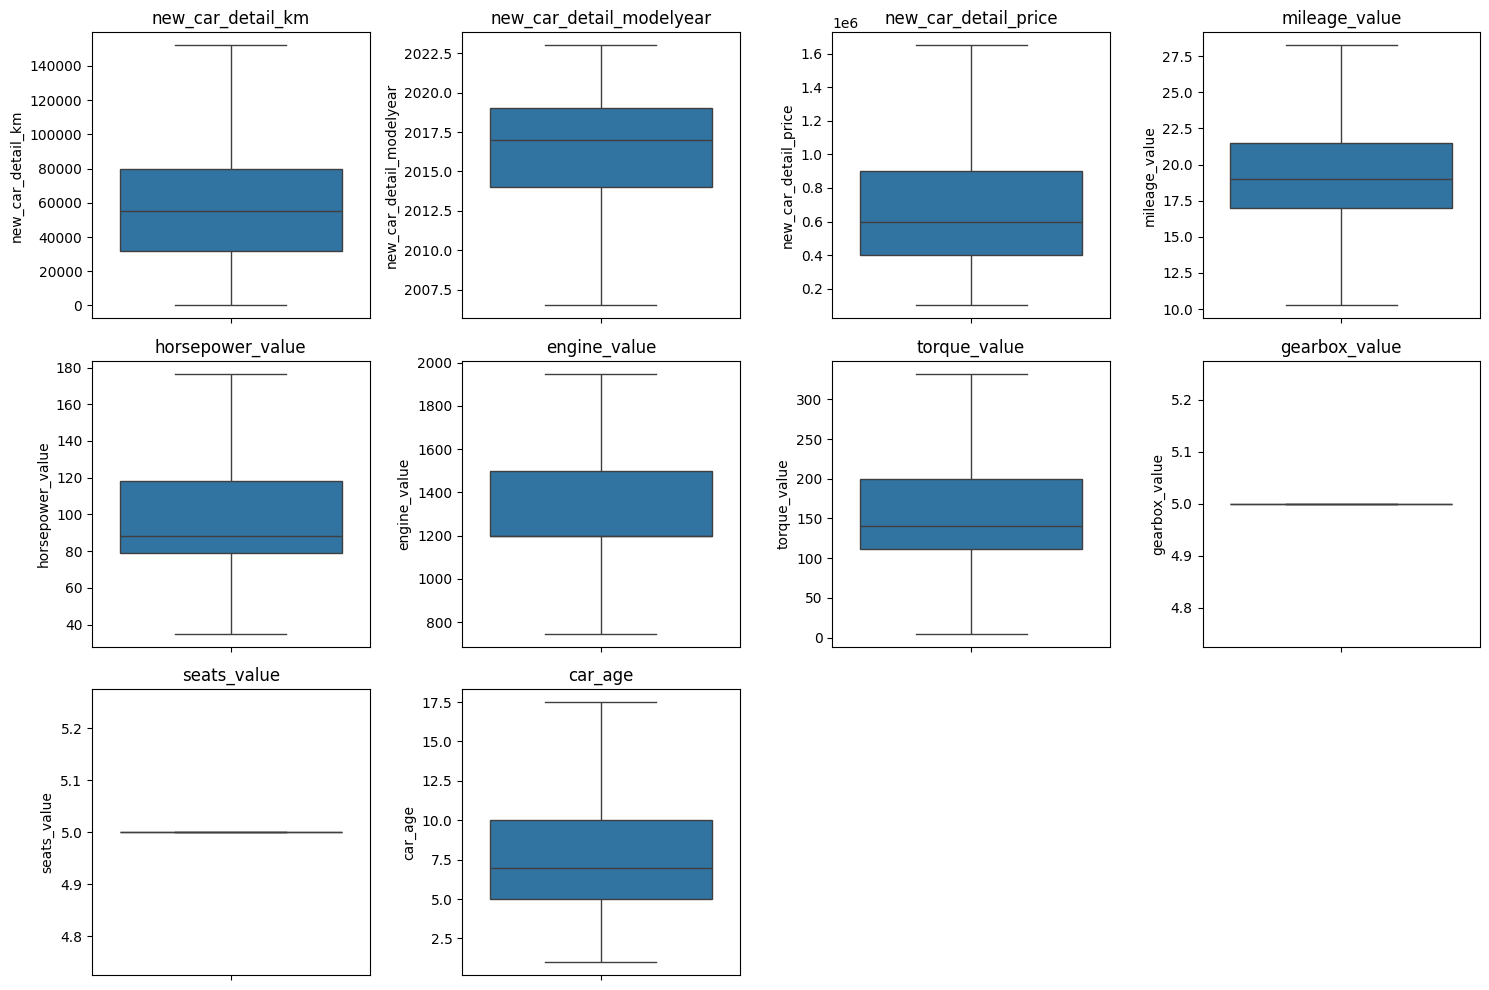

In [342]:
df = pd.read_csv('Cars_iqr_treated.csv')

# Select numerical columns for boxplot
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Create boxplots for each numerical column
plt.figure(figsize=(15, 10))  # Adjust figure size for better visualization

for i, col in enumerate(numerical_cols):
    plt.subplot(3, 4, i + 1)  # Adjust the grid layout as needed
    sns.boxplot(y=df[col])
    plt.title(col)
    plt.tight_layout()

plt.show()

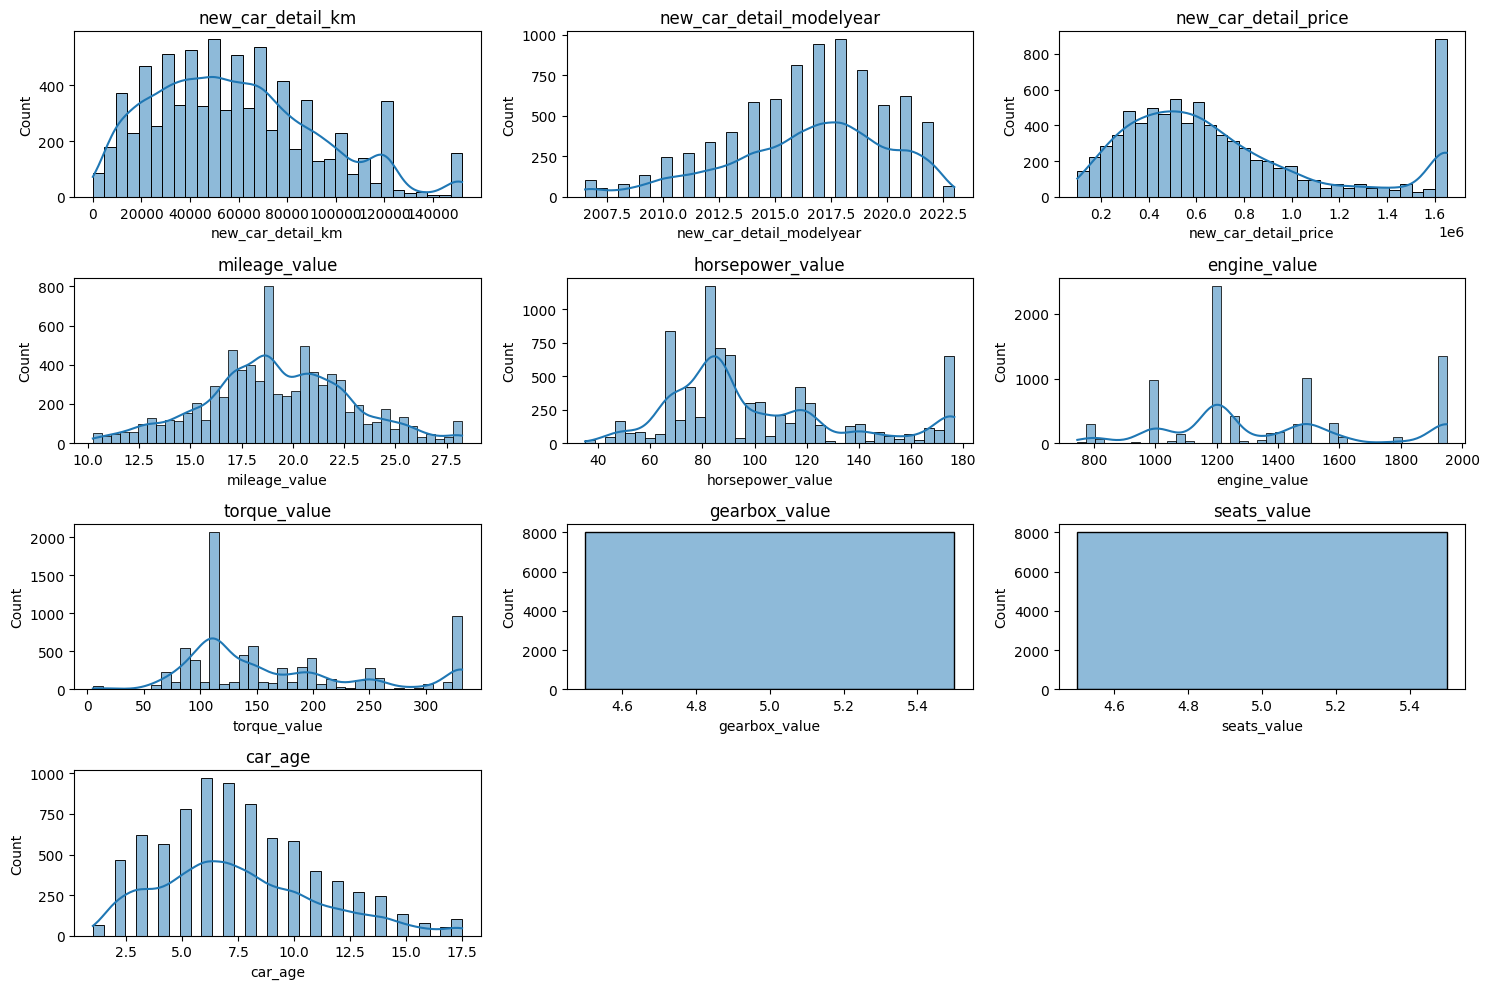

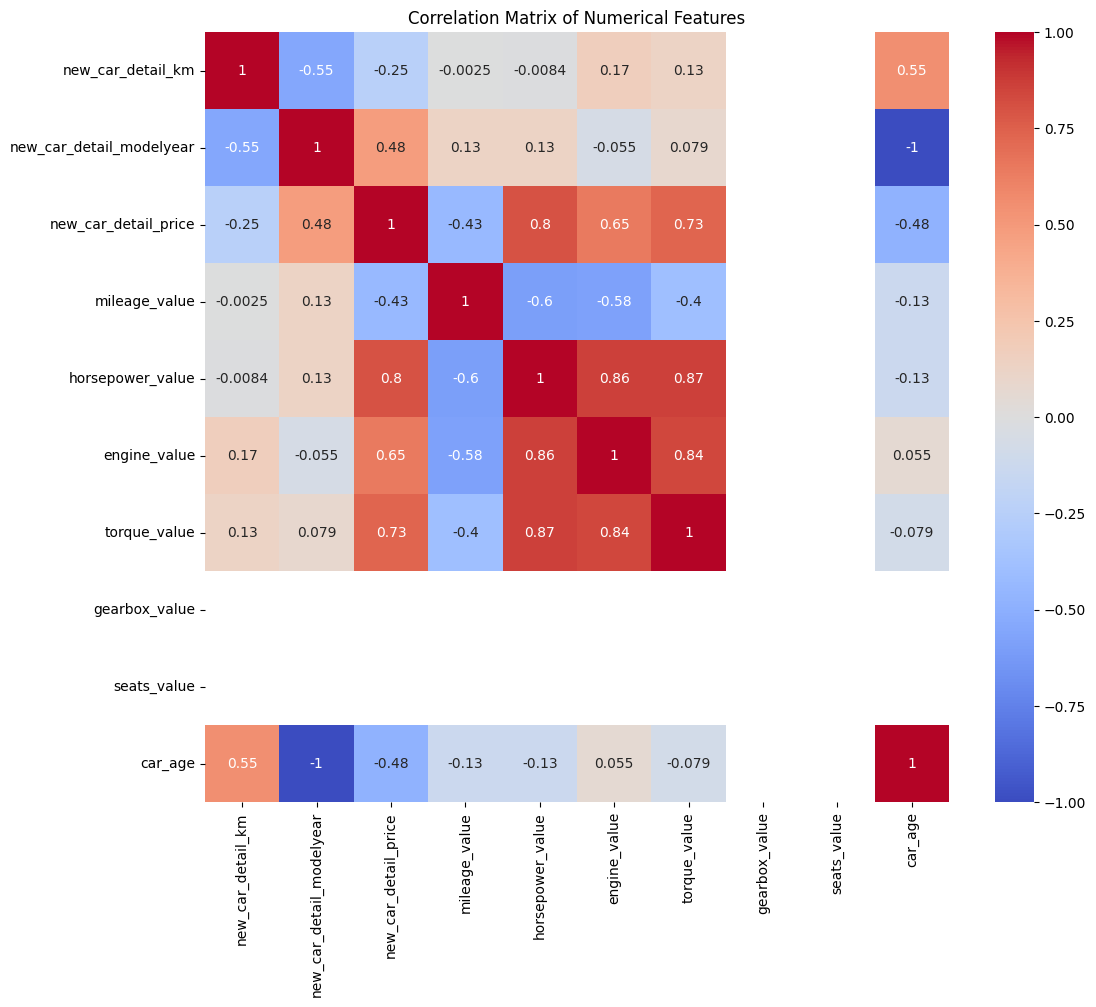


Correlation with Price:
 new_car_detail_price        1.000000
horsepower_value            0.802302
torque_value                0.727315
engine_value                0.645483
new_car_detail_modelyear    0.479733
new_car_detail_km          -0.248676
mileage_value              -0.431772
car_age                    -0.479733
gearbox_value                    NaN
seats_value                      NaN
Name: new_car_detail_price, dtype: float64


In [344]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the preprocessed data
df = pd.read_csv('Cars_iqr_treated.csv')

# Data Visualization: Histograms for numerical features
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(4, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()

# Correlation Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Feature Selection (Example: Correlation with price)
price_correlations = correlation_matrix['new_car_detail_price'].sort_values(ascending=False)
print("\nCorrelation with Price:\n", price_correlations)

In [346]:
df = pd.read_csv('Cars_iqr_treated.csv')

# Select numerical features for VIF calculation
numerical_cols = ['mileage_value', 'car_age', 'new_car_detail_km','new_car_detail_modelyear', 'horsepower_value', 'torque_value','new_car_detail_price']
X = df[numerical_cols]

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Display VIF values
vif_data

,feature,VIF
0,mileage_value,1.950988
1,car_age,11.908400
2,new_car_detail_km,1.606668
3,new_car_detail_modelyear,141.909881
4,horsepower_value,7.512647
5,torque_value,5.206260
6,new_car_detail_price,5.095642


In [348]:
# drop seats_value and some highly correlated columns
df = pd.read_csv('Cars_iqr_treated.csv')

# Drop the specified columns
df_processed = df.drop(columns=['new_car_detail_modelyear','seats_value','gearbox_value'], errors='ignore')

# Save the modified DataFrame
df_processed.to_csv("Cars_iqr_treated2.csv", index=False)

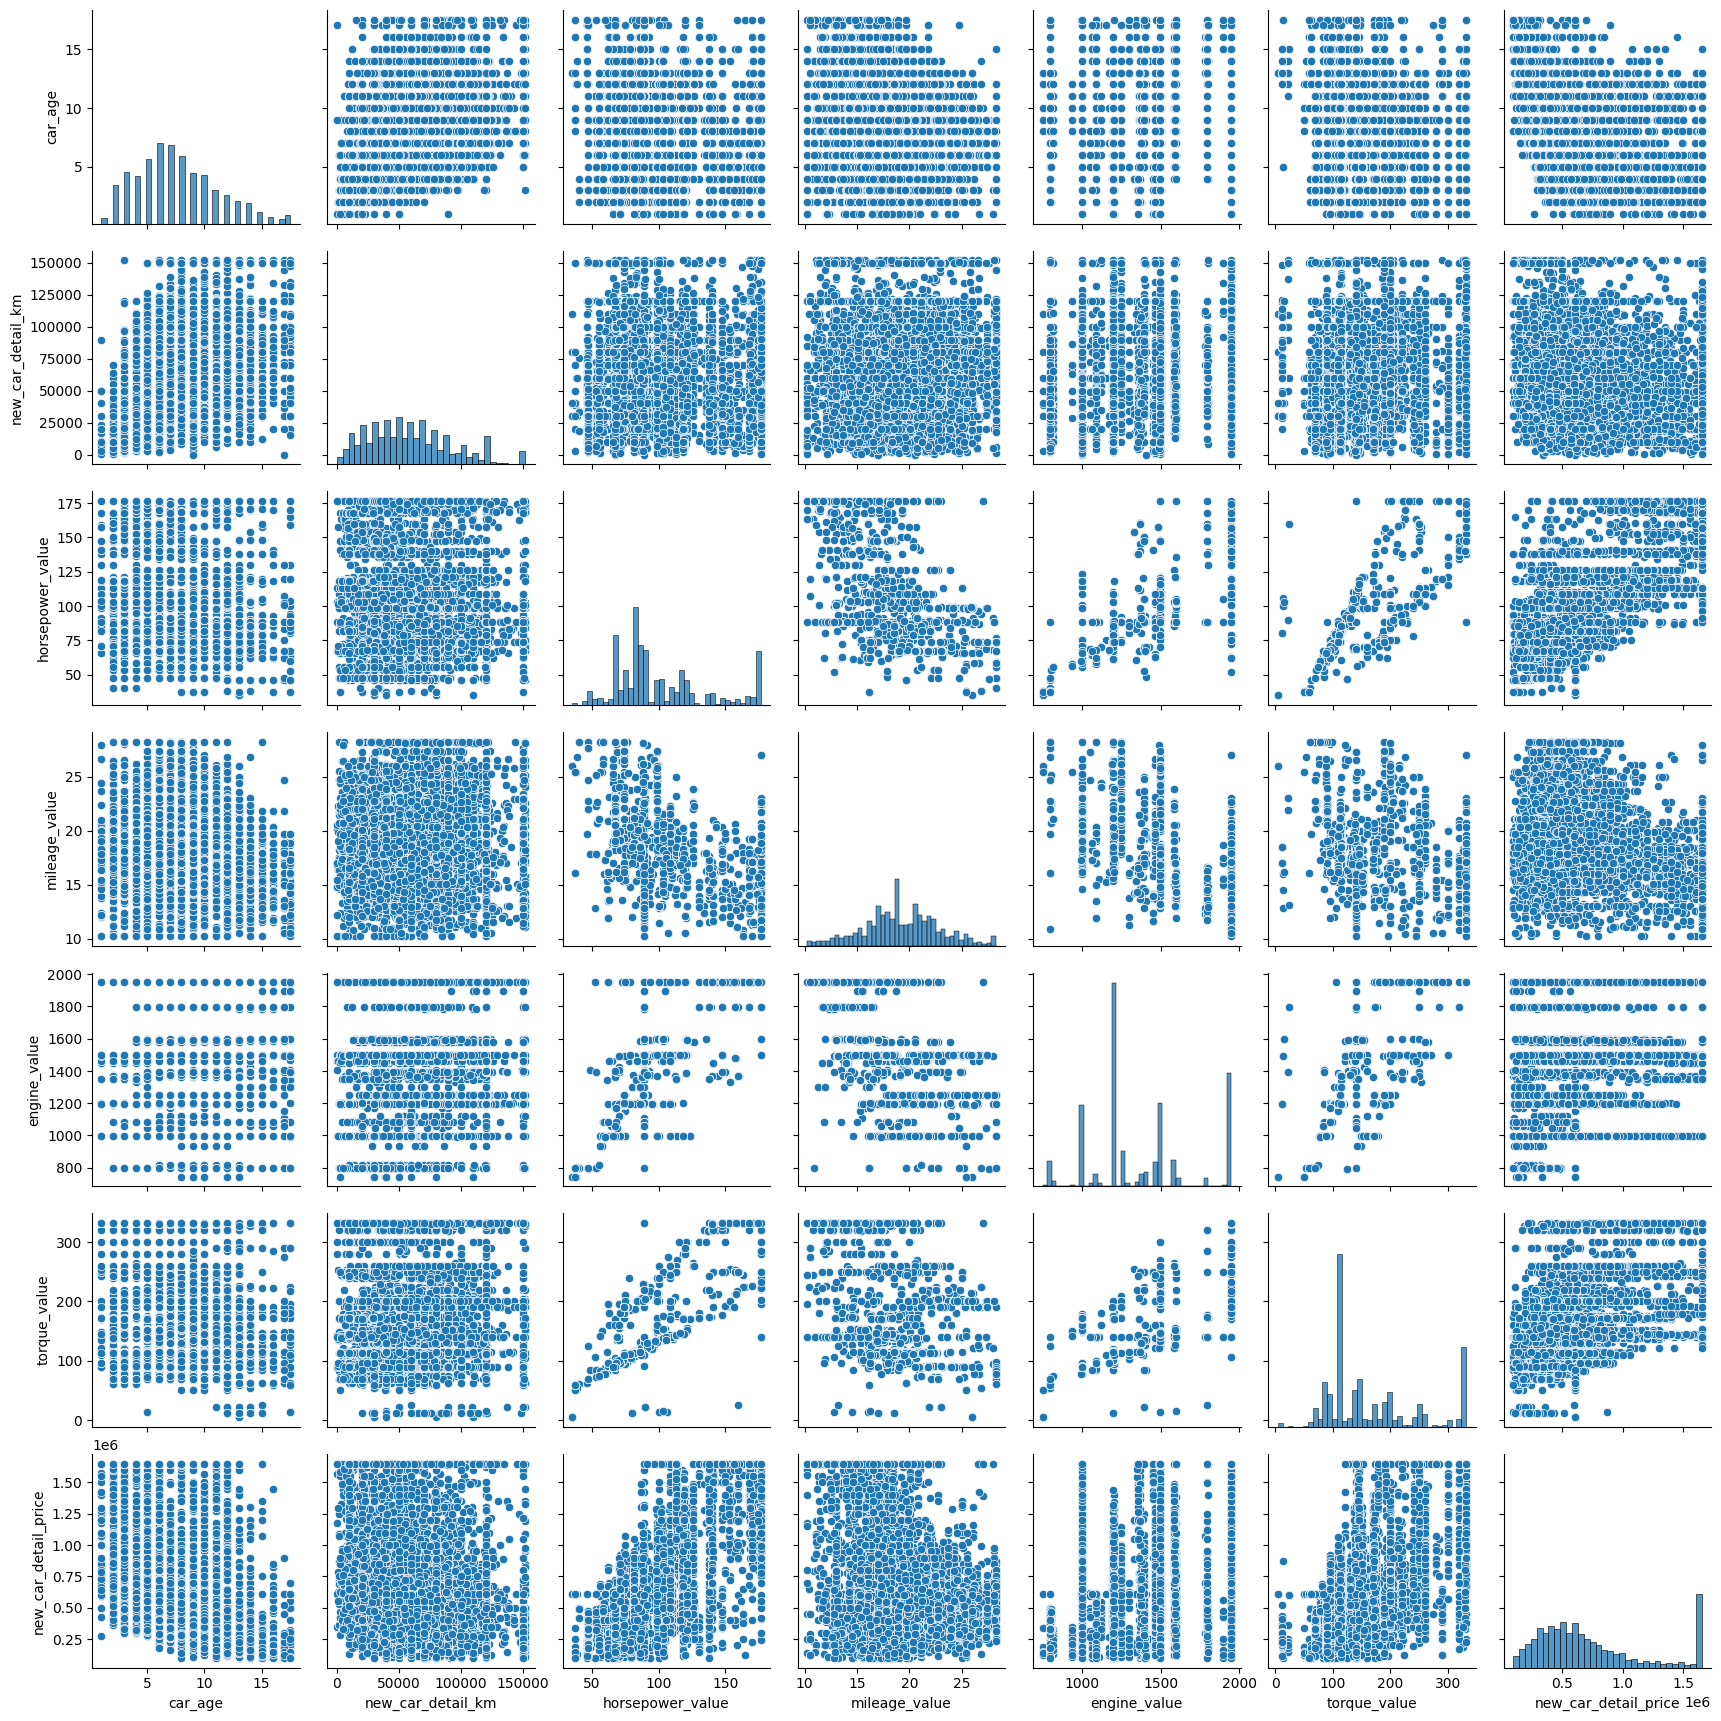

In [350]:
df = pd.read_csv('Cars_iqr_treated2.csv')
# Select the features for the scatter plot
features_to_plot = ['car_age', 'new_car_detail_km', 'horsepower_value', 'mileage_value', 'engine_value', 'torque_value']

# Create the scatter plot matrix
sns.pairplot(df[features_to_plot + ['new_car_detail_price']])
plt.show()

In [352]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import joblib

# Load the dataset
df = pd.read_csv('Cars_iqr_treated2.csv')

# Columns for label encoding
label_encode_cols = ['new_car_detail_model']

# Columns for one-hot encoding
onehot_encode_cols = ['new_car_detail_bt', 'new_car_detail_transmission', 'new_car_detail_ft', 'new_car_detail_owner', 'City']


# Initialize label encoders
label_encoders = {}
for col in label_encode_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Initialize one-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform the one-hot encoder
encoded_features = ohe.fit_transform(df[onehot_encode_cols])

# Get feature names for the encoded columns
encoded_feature_names = list(ohe.get_feature_names_out(onehot_encode_cols))

# Create a new DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

# Concatenate the encoded features with the original DataFrame
df = pd.concat([df, encoded_df], axis=1)

# Drop original categorical columns
df = df.drop(columns=onehot_encode_cols, axis=1)

# Save the processed DataFrame
df.to_csv('Cars_encoded.csv', index=False)

# Save the label encoders and one-hot encoder
joblib.dump(label_encoders, 'label_encoders.joblib')
joblib.dump(ohe, 'onehot_encoder.joblib')

['onehot_encoder.joblib']

In [354]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8026 entries, 0 to 8025
Data columns (total 35 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   new_car_detail_km                      8026 non-null   float64
 1   new_car_detail_model                   8026 non-null   int32  
 2   new_car_detail_price                   8026 non-null   float64
 3   mileage_value                          8026 non-null   float64
 4   horsepower_value                       8026 non-null   float64
 5   engine_value                           8026 non-null   float64
 6   torque_value                           8026 non-null   float64
 7   car_age                                8026 non-null   float64
 8   new_car_detail_bt_Convertibles         8026 non-null   float64
 9   new_car_detail_bt_Coupe                8026 non-null   float64
 10  new_car_detail_bt_Hatchback            8026 non-null   float64
 11  new_

In [356]:
df.describe()

,new_car_detail_km,new_car_detail_model,new_car_detail_price,mileage_value,horsepower_value,engine_value,torque_value,car_age,new_car_detail_bt_Convertibles,new_car_detail_bt_Coupe,...,new_car_detail_owner_2nd Owner,new_car_detail_owner_3rd Owner,new_car_detail_owner_4th Owner,new_car_detail_owner_5th Owner,City_Bangalore,City_Chennai,City_Delhi,City_Hyderabad,City_Jaipur,City_Kolkata
count,8026.000000,8026.000000,8.026000e+03,8026.000000,8026.000000,8026.000000,8026.000000,8026.000000,8026.000000,8026.000000,...,8026.000000,8026.000000,8026.000000,8026.000000,8026.000000,8026.000000,8026.00000,8026.000000,8026.000000,8026.000000
mean,58537.962746,128.566409,7.216625e+05,19.227146,100.347842,1364.715986,167.224234,7.544979,0.000748,0.000997,...,0.241714,0.044730,0.009594,0.002243,0.177922,0.168702,0.17381,0.179043,0.135310,0.165213
std,33517.820391,68.820081,4.398650e+05,3.559782,34.564230,329.615308,81.686460,3.659099,0.027333,0.031558,...,0.428149,0.206723,0.097483,0.047307,0.382471,0.374512,0.37897,0.383412,0.342076,0.371396
min,0.000000,0.000000,1.000000e+05,10.250000,35.000000,745.500000,4.800000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,32000.000000,73.000000,4.000000e+05,17.000000,78.900000,1197.000000,111.800000,5.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,55000.000000,136.000000,6.000000e+05,18.970000,88.500000,1199.000000,140.000000,7.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,80000.000000,163.000000,9.000000e+05,21.500000,118.000000,1498.000000,200.000000,10.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,152000.000000,276.000000,1.650000e+06,28.250000,176.650000,1949.500000,332.300000,17.500000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


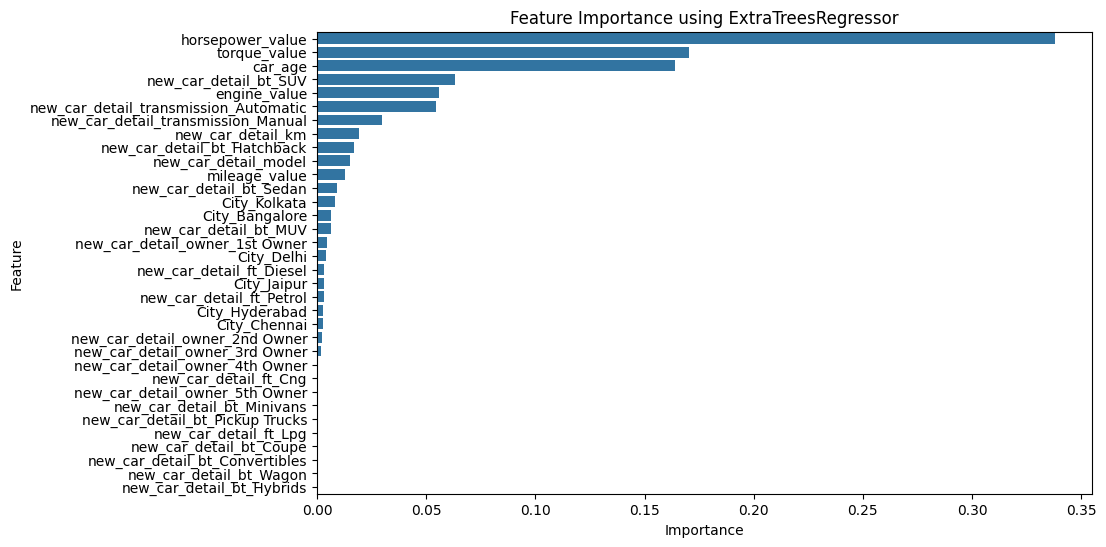

,Feature,Importance
3,horsepower_value,0.338018
5,torque_value,0.170411
6,car_age,0.164139
14,new_car_detail_bt_SUV,0.063288
4,engine_value,0.055918
17,new_car_detail_transmission_Automatic,0.054680
18,new_car_detail_transmission_Manual,0.029702
0,new_car_detail_km,0.019091
9,new_car_detail_bt_Hatchback,0.017042
1,new_car_detail_model,0.015020


In [360]:
# feature importance use extratrees regresssor

import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('Cars_encoded.csv')

# Define features (X) and target (y)
X = df.drop('new_car_detail_price', axis=1)
y = df['new_car_detail_price']

# Initialize and train the ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X, y)

# Get feature importances
feature_importances = model.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance using ExtraTreesRegressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Print the feature importance scores
feature_importance_df

In [362]:
df.shape

(8026, 35)

In [364]:
print(X.shape)
print(y.shape)

(8026, 34)
(8026,)


In [366]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

# Load your dataset
df = pd.read_csv('Cars_encoded.csv')

# Separate features (X) and target (y)
X = df.drop("new_car_detail_price", axis=1)
y = df["new_car_detail_price"]

# Initialize StandardScaler
scaler = StandardScaler()

# Scaling the data
X_scaled = scaler.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "KNN": KNeighborsRegressor(n_neighbors=5)
}

results = {}

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {"MSE": mse, "MAE": mae, "RMSE": rmse, "R-squared": r2}

# Print the evaluation results
for name, metrics in results.items():
    print(f"Model: {name}")
    print(f"  MAE: {metrics['MAE']:.4f}")
    print(f"  MSE: {metrics['MSE']:.4f}")
    print(f"  RMSE: {metrics['RMSE']:.4f}")
    print(f"  R-squared: {metrics['R-squared']:.4f}")
    print("-" * 20)


Model: Linear Regression
  MAE: 125948.4249
  MSE: 31373999399.2754
  RMSE: 177127.0713
  R-squared: 0.8364
--------------------
Model: Decision Tree
  MAE: 90030.5106
  MSE: 22605685865.5044
  RMSE: 150351.8735
  R-squared: 0.8821
--------------------
Model: Random Forest
  MAE: 69301.0516
  MSE: 12333291852.0536
  RMSE: 111055.3549
  R-squared: 0.9357
--------------------
Model: Gradient Boosting
  MAE: 85120.9809
  MSE: 15443716222.2942
  RMSE: 124272.7493
  R-squared: 0.9195
--------------------
Model: KNN
  MAE: 122638.4807
  MSE: 36246309414.6949
  RMSE: 190384.6354
  R-squared: 0.8110
--------------------


In [368]:
#hypertuning randomforest grid search

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import joblib

# Load your dataset
df = pd.read_csv('Cars_encoded.csv')

# Separate features (X) and target (y)
X = df.drop("new_car_detail_price", axis=1)
y = df["new_car_detail_price"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'random_state': [42]
}

# Initialize the model
rf = RandomForestRegressor()

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best negative MSE:", grid_search.best_score_)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Cross-validation score
cv_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validation MSE scores:", -cv_scores)
print("Average CV MSE:", -cv_scores.mean())

# Feature importance
feature_importance = pd.DataFrame({'feature': X.columns, 
                                   'importance': best_rf_model.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("Top 10 important features:")
print(feature_importance.head(10))

# Save the best model
import joblib
joblib.dump(best_rf_model, 'best_rf_model.joblib')



Fitting 5 folds for each of 1920 candidates, totalling 9600 fits


C:\Users\mona2\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
3200 fits failed out of a total of 9600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2047 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mona2\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mona2\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "C:\Users\mona2\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\mona2\anaconda3\Lib\site-pac

Best parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400, 'random_state': 42}
Best negative MSE: -13371060107.836157
Mean Squared Error: 13256674106.652365
R-squared Score: 0.9308720943171883
Cross-validation MSE scores: [2.04026296e+10 1.26951404e+10 1.36400626e+10 1.78408014e+10
 2.51789020e+10]
Average CV MSE: 17951507219.162758
Top 10 important features:
                                  feature  importance
3                        horsepower_value    0.184849
5                            torque_value    0.169775
6                                 car_age    0.114196
4                            engine_value    0.108103
17  new_car_detail_transmission_Automatic    0.061340
2                           mileage_value    0.052961
18     new_car_detail_transmission_Manual    0.051662
14                  new_car_detail_bt_SUV    0.049716
9             new_car_detail_bt_Hatchback    0.046633
0         

['best_rf_model.joblib']

In [370]:
predictions=best_rf_model.predict(X_test)

In [372]:
predictions

array([ 646704.58510369,  388721.46247135, 1617708.05555556, ...,
        205947.86074542,  716806.54166667,  570940.63718104])

<Axes: xlabel='new_car_detail_price', ylabel='Count'>

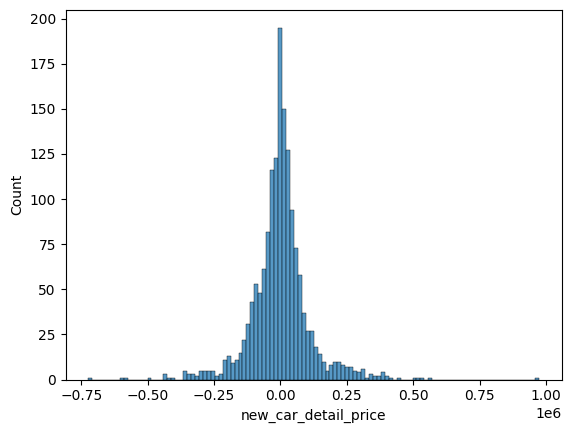

In [376]:
sns.histplot(y_test-predictions)

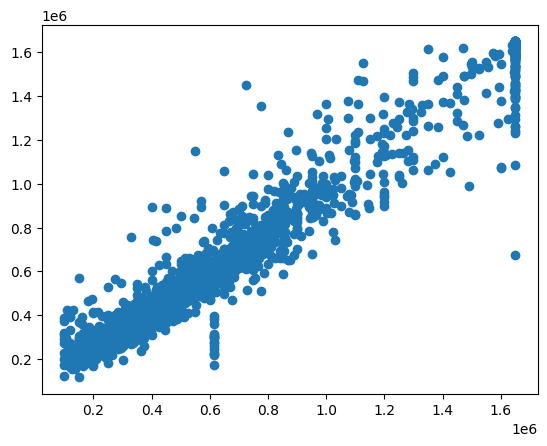

In [378]:
plt.scatter(y_test,predictions)

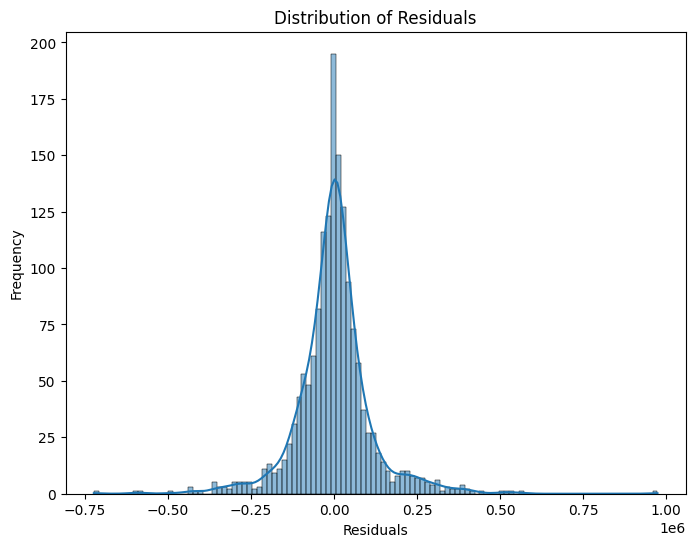

In [380]:
residuals = y_test - y_pred

# Create a distribution plot of the residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In [382]:
difference=y_test-y_pred

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': y_pred})

# Save or display the comparison
print(comparison_df)
comparison_df.to_csv('comparison_results.csv', index=False)


      Actual Price  Predicted Price
5865      759000.0     6.467046e+05
3555      460000.0     3.887215e+05
3032     1650000.0     1.617708e+06
7060      335000.0     2.731670e+05
318      1147000.0     8.882069e+05
...            ...              ...
4606      575000.0     5.463638e+05
2943      800000.0     8.553427e+05
2441      200000.0     2.059479e+05
921       808000.0     7.168065e+05
322       755000.0     5.709406e+05

[1606 rows x 2 columns]


In [416]:
import joblib

encoders = joblib.load("label_encoders.joblib")  # Adjust filename if needed
print(type(encoders))  # Should be <class 'sklearn.preprocessing.LabelEncoder'>
print(encoders.keys())  # If it's a dictionary, this will show available keys


<class 'dict'>
dict_keys(['new_car_detail_model'])


In [418]:
model_encoder = encoders["new_car_detail_model"]

In [186]:

#Optimization using Lasso and Ridge regularization
import pandas as pd
import numpy as np

df = pd.read_csv('Cars_iqr_treated2.csv')

# Feature Engineering
def engineer_features(df):

 
    # Create interaction features
    df['age_km'] = df['car_age'] * df['new_car_detail_km']
    df['age_mileage_interaction'] = df['car_age'] * df['mileage_value']
    df['power_torque_interaction'] = df['horsepower_value'] * df['torque_value']
    df['log_km'] = np.log1p(df['new_car_detail_km'])
    df['log_mileage'] = np.log1p(df['mileage_value'])
    df['power_to_age_ratio'] = df['horsepower_value'] / (df['car_age'] + 1)  # Adding 1 to avoid division by zero
    df['torque_to_mileage_ratio'] = df['torque_value'] / (df['new_car_detail_km'] + 1)
    
    # Binning example
    df['age_category'] = pd.cut(df['car_age'], bins=[0, 10, 20, np.inf], labels=['New', 'Slightly Used', 'Old'])
    return df

# Call the function to engineer features and update the DataFrame
df = engineer_features(df)  # Assign the result back to df

# Check the dataset
print(df[['car_age', 'new_car_detail_km', 'mileage_value', 'torque_value', 'horsepower_value',
                'age_mileage_interaction', 'power_torque_interaction', 'log_km', 'log_mileage',
                'power_to_age_ratio', 'torque_to_mileage_ratio']].head())

# Save the dataframe to cars_modified_features.csv
df.to_csv("cars_modified_features.csv", index=False)

   car_age  new_car_detail_km  mileage_value  torque_value  horsepower_value  \
0      9.0           120000.0          23.10         90.00             67.04   
1      6.0            32706.0          17.00        150.00            121.31   
2      6.0            11949.0          23.84        114.00             84.00   
3     10.0            17794.0          19.10        113.75             81.86   
4      9.0            60000.0          23.65        200.00             88.50   

   age_mileage_interaction  power_torque_interaction     log_km  log_mileage  \
0                   207.90                  6033.600  11.695255     3.182212   
1                   102.00                 18196.500  10.395344     2.890372   
2                   143.04                  9576.000   9.388487     3.212455   
3                   191.00                  9311.575   9.786673     3.000720   
4                   212.85                 17700.000  11.002117     3.204777   

   power_to_age_ratio  torque_to_milea

In [192]:
df = pd.read_csv('cars_modified_features.csv')

# Select numerical features for VIF calculation
numerical_cols = [ 'age_km', 
                'age_mileage_interaction', 'power_torque_interaction', 'log_km', 'log_mileage',
                'power_to_age_ratio', 'torque_to_mileage_ratio']
X = df[numerical_cols]

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

# Display VIF values
vif_data

,feature,VIF
0,age_km,10.034209
1,age_mileage_interaction,25.139951
2,power_torque_interaction,5.265797
3,log_km,333.469800
4,log_mileage,356.521341
5,power_to_age_ratio,10.939036
6,torque_to_mileage_ratio,1.061697



Lasso Regression Results:
Best alpha: 11.2884
Train MSE: 26467682149.29
Test MSE: 27149944745.49
Train R2 Score: 0.8634
Test R2 Score: 0.8584

Ridge Regression Results:
Best alpha: 4.2813
Train MSE: 27012889300.39
Test MSE: 27676254283.19
Train R2 Score: 0.8606
Test R2 Score: 0.8557

Top 10 Lasso Feature Importances:
power_torque_interaction power_to_age_ratio   -942819.722681
power_torque_interaction                      -684261.471509
horsepower_value power_torque_interaction      684058.031841
torque_value power_to_age_ratio                605428.779802
car_age power_to_age_ratio                     589002.329741
torque_value horsepower_value                 -532641.646747
new_car_detail_km torque_to_mileage_ratio      494875.911960
age_km torque_to_mileage_ratio                -454544.095295
torque_value                                   403437.539889
mileage_value                                 -397373.728182
dtype: float64

Top 10 Ridge Feature Importances:
power_torque_interac

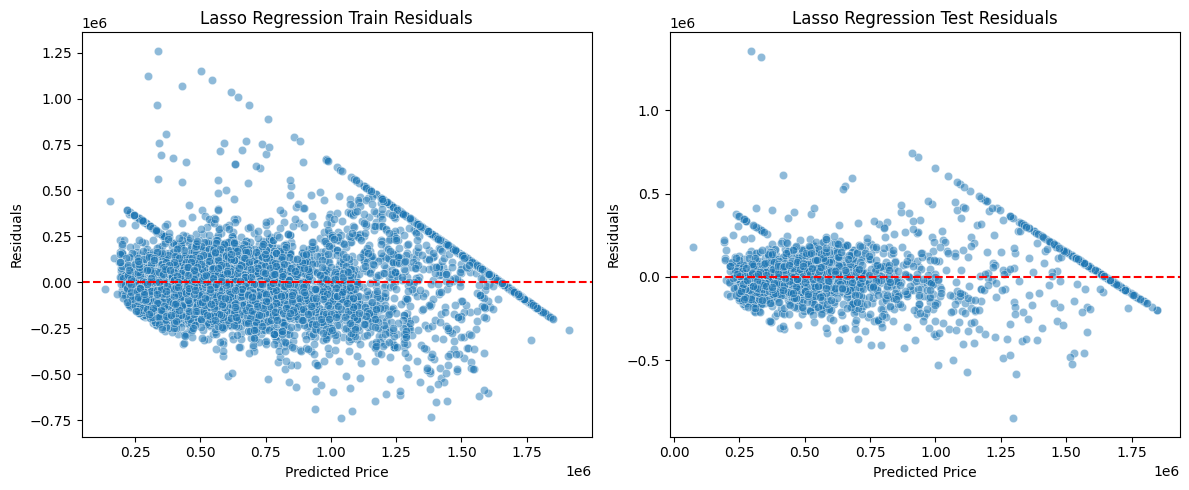

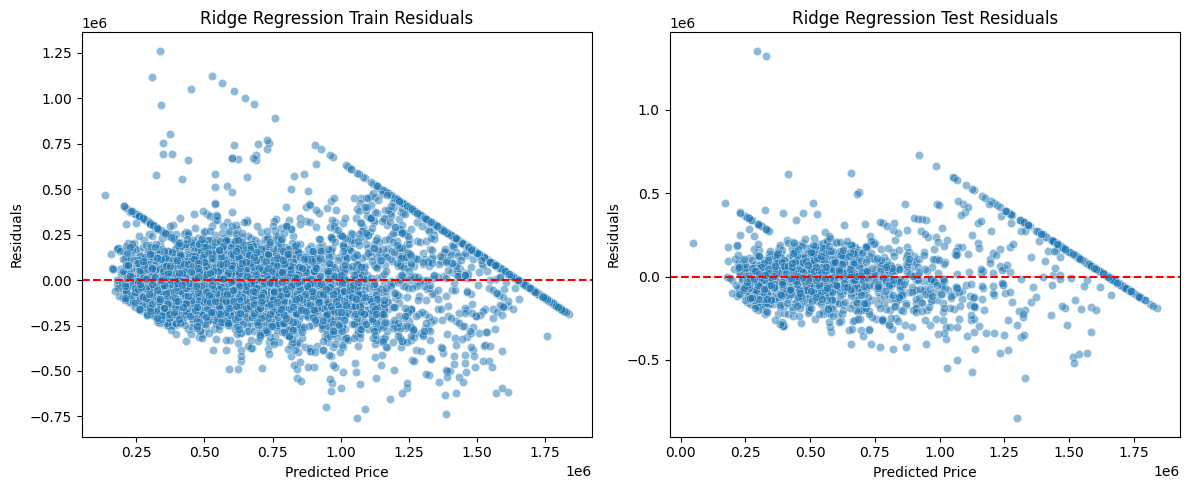

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

def create_features(df):
       
    df['power_torque_interaction'] = df['horsepower_value'] * df['torque_value']
    df['power_to_age_ratio'] = df['horsepower_value'] / (df['car_age'] + 1)  # Adding 1 to avoid division by zero
    df['torque_to_mileage_ratio'] = df['torque_value'] / (df['new_car_detail_km'] + 1)
    df['age_km'] = df['car_age'] * df['new_car_detail_km']
   
# One-hot encoding
    onehot_columns = ['new_car_detail_bt', 'new_car_detail_transmission', 'new_car_detail_ft', 
                  'new_car_detail_owner', 'City', 'new_car_detail_model']

# Perform one-hot encoding
    df = pd.get_dummies(df, columns=onehot_columns, drop_first=True)
    
    return df

def train_regularization_models(X, y):
    """Train and evaluate Lasso & Ridge models with polynomial features."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Polynomial Features
    poly = PolynomialFeatures(degree=2, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_test_scaled = scaler.transform(X_test_poly)

    # Hyperparameter grid
    alpha_grid = {'alpha': np.logspace(-4, 4, 20)}

    # Models
    lasso = Lasso(random_state=42, max_iter=10000)
    ridge = Ridge(random_state=42)

    # GridSearchCV
    lasso_cv = GridSearchCV(lasso, alpha_grid, cv=5, scoring='neg_mean_squared_error')
    ridge_cv = GridSearchCV(ridge, alpha_grid, cv=5, scoring='neg_mean_squared_error')

    # Fit models
    lasso_cv.fit(X_train_scaled, y_train)
    ridge_cv.fit(X_train_scaled, y_train)

    # Best models
    best_lasso = lasso_cv.best_estimator_
    best_ridge = ridge_cv.best_estimator_

    # Predictions
    y_train_pred_lasso = best_lasso.predict(X_train_scaled)
    y_test_pred_lasso = best_lasso.predict(X_test_scaled)
    
    y_train_pred_ridge = best_ridge.predict(X_train_scaled)
    y_test_pred_ridge = best_ridge.predict(X_test_scaled)

    # Compute residuals
    train_residuals_lasso = y_train - y_train_pred_lasso
    test_residuals_lasso = y_test - y_test_pred_lasso

    train_residuals_ridge = y_train - y_train_pred_ridge
    test_residuals_ridge = y_test - y_test_pred_ridge

    # Performance metrics
    results = {
        'lasso': {
            'best_alpha': best_lasso.alpha,
            'train_mse': mean_squared_error(y_train, y_train_pred_lasso),
            'test_mse': mean_squared_error(y_test, y_test_pred_lasso),
            'train_r2': r2_score(y_train, y_train_pred_lasso),
            'test_r2': r2_score(y_test, y_test_pred_lasso),
        },
        'ridge': {
            'best_alpha': best_ridge.alpha,
            'train_mse': mean_squared_error(y_train, y_train_pred_ridge),
            'test_mse': mean_squared_error(y_test, y_test_pred_ridge),
            'train_r2': r2_score(y_train, y_train_pred_ridge),
            'test_r2': r2_score(y_test, y_test_pred_ridge),
        }
    }

    return results, scaler, best_lasso, best_ridge, poly, train_residuals_lasso, test_residuals_lasso, train_residuals_ridge, test_residuals_ridge, y_train_pred_lasso, y_test_pred_lasso, y_train_pred_ridge, y_test_pred_ridge, y_train, y_test, poly.get_feature_names_out(X.columns)

# Residual Plot Function
def plot_residuals(y_train, y_train_pred, y_test, y_test_pred, model_name):
    """Plots residuals for train and test sets."""
    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred

    plt.figure(figsize=(12, 5))
    
    # Train residuals plot
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_train_pred, y=train_residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Predicted Price")
    plt.ylabel("Residuals")
    plt.title(f"{model_name} Train Residuals")

    # Test residuals plot
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test_pred, y=test_residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel("Predicted Price")
    plt.ylabel("Residuals")
    plt.title(f"{model_name} Test Residuals")

    plt.tight_layout()
    plt.show()

# Save the models, scaler, poly transformer, and one-hot encoded columns list
def save_model(best_lasso, best_ridge, scaler, poly, onehot_columns):
    model_data = {
        'best_lasso': best_lasso,
        'best_ridge': best_ridge,
        'scaler': scaler,
        'poly': poly,
        'onehot_columns': onehot_columns
    }

    # Save the model and transformers using joblib
    joblib.dump(model_data, 'best_model_and_transformers.joblib')

# In your training function, call the save function after training the models
def main():
    df = pd.read_csv('Cars_iqr_treated2.csv')
    df.dropna(inplace=True)
    
    # Feature engineering
    df = create_features(df)

    feature_cols = ['car_age', 'new_car_detail_km', 'age_km','mileage_value', 'torque_value', 'horsepower_value',
                'power_torque_interaction', 'power_to_age_ratio', 'torque_to_mileage_ratio']
    X = df[feature_cols]
    y = df['new_car_detail_price']

    # Train models and get results
    results, scaler, best_lasso, best_ridge, poly, train_residuals_lasso, test_residuals_lasso, train_residuals_ridge, test_residuals_ridge, y_train_pred_lasso, y_test_pred_lasso, y_train_pred_ridge, y_test_pred_ridge, y_train, y_test, feature_names = train_regularization_models(X, y)

    # Save the best models and transformers
    save_model(best_lasso, best_ridge, scaler, poly, df.columns)

    # Print metrics
    print("\nLasso Regression Results:")
    print(f"Best alpha: {results['lasso']['best_alpha']:.4f}")
    print(f"Train MSE: {results['lasso']['train_mse']:.2f}")
    print(f"Test MSE: {results['lasso']['test_mse']:.2f}")
    print(f"Train R2 Score: {results['lasso']['train_r2']:.4f}")
    print(f"Test R2 Score: {results['lasso']['test_r2']:.4f}")

    print("\nRidge Regression Results:")
    print(f"Best alpha: {results['ridge']['best_alpha']:.4f}")
    print(f"Train MSE: {results['ridge']['train_mse']:.2f}")
    print(f"Test MSE: {results['ridge']['test_mse']:.2f}")
    print(f"Train R2 Score: {results['ridge']['train_r2']:.4f}")
    print(f"Test R2 Score: {results['ridge']['test_r2']:.4f}")

    # Feature Importance: Top 10 Features for Lasso and Ridge
    print("\nTop 10 Lasso Feature Importances:")
    lasso_coef = pd.Series(best_lasso.coef_, index=feature_names).sort_values(key=abs, ascending=False)
    print(lasso_coef.head(10))

    print("\nTop 10 Ridge Feature Importances:")
    ridge_coef = pd.Series(best_ridge.coef_, index=feature_names).sort_values(key=abs, ascending=False)
    print(ridge_coef.head(10))

    # Plot residuals
    plot_residuals(y_train, y_train_pred_lasso, y_test, y_test_pred_lasso, "Lasso Regression")
    plot_residuals(y_train, y_train_pred_ridge, y_test, y_test_pred_ridge, "Ridge Regression")

if __name__ == "__main__":
    main()




In [422]:
#Lasso and Ridge and didn't work as expected, so I decided to went with random forest model
%%writefile carapp2.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# Load the trained model and label encoders
model = joblib.load('best_rf_model.joblib')
label_encoders = joblib.load('label_encoders.joblib')

# Extract individual encoders
model_encoder = label_encoders.get("new_car_detail_model")  

# Define categorical variable mappings
CATEGORY_MAPPINGS = {
    'City': ['Bangalore', 'Chennai', 'Delhi', 'Hyderabad', 'Jaipur', 'Kolkata'],
    'new_car_detail_owner': ['First', 'Second', 'Third', 'Fourth & Above'],
    'new_car_detail_transmission': ['Automatic', 'Manual'],
    'new_car_detail_ft': ['Petrol', 'Diesel', 'Lpg', 'Cng', 'Electric'],
    'new_car_detail_bt': ['Hatchback', 'SUV', 'Sedan', 'MUV', 'Coupe', 'Minivans', 'Pickup Trucks', 'Convertibles', 'Hybrids', 'Wagon']
}

def encode_features(input_data):
    """Encodes user input to match model's training format"""
    features = {}
    
    # Encode label-encoded fields
     features['new_car_detail_model'] = model_encoder.transform([input_data['new_car_detail_model']])[0]
    
    # Numeric features
    features['car_age'] = input_data['car_age']
    features['new_car_detail_km'] = input_data['new_car_detail_km']
    features['horsepower_value'] = input_data['horsepower_value']
    features['mileage_value'] = input_data['mileage_value']
    features['engine_value'] = input_data['engine_value']
    features['torque_value'] = input_data['torque_value']
    
    # One-hot encoding for categorical variables
    for category, values in CATEGORY_MAPPINGS.items():
        for value in values:
            features[f"{category}_{value}"] = 1 if input_data[category] == value else 0
    
    # Convert to DataFrame
    encoded_df = pd.DataFrame([features])

    # Ensure all required features exist in the model
    for col in model.feature_names_in_:
        if col not in encoded_df.columns:
            encoded_df[col] = 0  
    
    return encoded_df[model.feature_names_in_]

def main():
    st.set_page_config(page_title='Car Price Predictor', page_icon='🚗', layout='wide')
    st.title('🚗 Used Car Price Prediction')
    
    col1, col2 = st.columns(2)
    
    with col1:
        st.subheader('Basic Car Details')
        model_name = st.selectbox('Model', model_encoder.classes_)
        year = st.slider('Manufacturing Year', 2000, 2024, 2015)
        transmission = st.selectbox('Transmission', CATEGORY_MAPPINGS['new_car_detail_transmission'])
        fuel_type = st.selectbox('Fuel Type', CATEGORY_MAPPINGS['new_car_detail_ft'])
    
    with col2:
        st.subheader('Additional Details')
        body_type = st.selectbox('Body Type', CATEGORY_MAPPINGS['new_car_detail_bt'])
        ownership = st.selectbox('Ownership', CATEGORY_MAPPINGS['new_car_detail_owner'])
        city = st.selectbox('City', CATEGORY_MAPPINGS['City'])
        km_driven = st.number_input('Kilometers Driven', min_value=0, value=50000)
    
    st.subheader('Technical Specifications')
    horsepower = st.number_input('Horsepower (hp)', min_value=50, value=500)
    mileage = st.number_input('Mileage (kmpl)', min_value=5.0, value=400.0)
    engine_size = st.number_input('Engine Size (cc)', min_value=500, value=1500)
    torque = st.number_input('Torque (Nm)', min_value=50, value=200)
    
    car_age = 2024 - year
    
    if st.button('Predict Price'):
        try:
            input_data = {
                               'new_car_detail_model': model_name,
                'new_car_detail_transmission': transmission,
                'new_car_detail_ft': fuel_type,
                'new_car_detail_bt': body_type,
                'new_car_detail_owner': ownership,
                'City': city,
                'new_car_detail_km': km_driven,
                'car_age': car_age,
                'horsepower_value': horsepower,
                'mileage_value': mileage,
                'engine_value': engine_size,
                'torque_value': torque
            }
            
            encoded_input = encode_features(input_data)
            prediction = model.predict(encoded_input)[0]
            
            st.success(f'Estimated Price: ₹ {prediction:,.2f}')
            
        except Exception as e:
            st.error(f'An error occurred: {str(e)}')
            st.info('Please check the inputs and try again.')

if __name__ == '__main__':
    main()


Overwriting carapp2.py
